In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# show more colums
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Visualize the data


In [3]:
# Keep only the columns we want
cols = list(df.columns)
cols.remove("FlightDate")
cols.remove("Airline")
cols.remove("Tail_Number")
cols.remove("OriginAirportID")
cols.remove("DestAirportID")
cols.remove("DepTime")
cols.remove("TaxiOut")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

# Selecting a subset of the data
data = df.sample(100000)

# increase width or pairplot
sns.pairplot(data=data, y_vars=["ArrDelay"], x_vars=cols, size=5)

NameError: name 'df' is not defined

# Models

### 1. Baseline: Linear Regression on continuous variables

`Ideas? :`

1. If we use all variables (including the departure data), what about predicting the difference between EstimatedArrivalTime + DepartureDelay instead of ArrivalDelay? It will be more "difficult" (ass less dependent on departure delay) and probably more insightful (Because now, our $R^2$ is 0.99, which is not very interesting...)
2. Use bag of words / TF-IDF methods to predict the delay bucket?
3. Compute the Taxi-Out time average for all specific aircrafts / type of trips. We see below that it is a very important feature.

`Questions?:`

1. ArrDelay and ArrDelayMinutes are the same, right? If so, why do we need both?
2. What is CRS Estimated Time again?
3. What is CRSArrTime? Can we use it? It's a very relevant feature...


In [ ]:
cont_vars = [
    "ArrDelay",
    "DepTime",
    "DepDelay",
    "AirTime",
    "Distance",
    "CRSElapsedTime",
    "CRSDepTime",
    "DayOfWeek",
    "Year",
    "Month",
    "CRSArrTime",
    "AverageDelayPerFlightNumber",
    "AverageDelayPerDistanceGroup",
    "AverageDelayPerAircraft",
]

cont_df = df[cont_vars]

In [ ]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    cont_df.drop("ArrDelay", axis=1),
    cont_df["ArrDelay"],
    test_size=0.2,
    random_state=1601,
)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 105.06
Coefficient of determination: 0.95


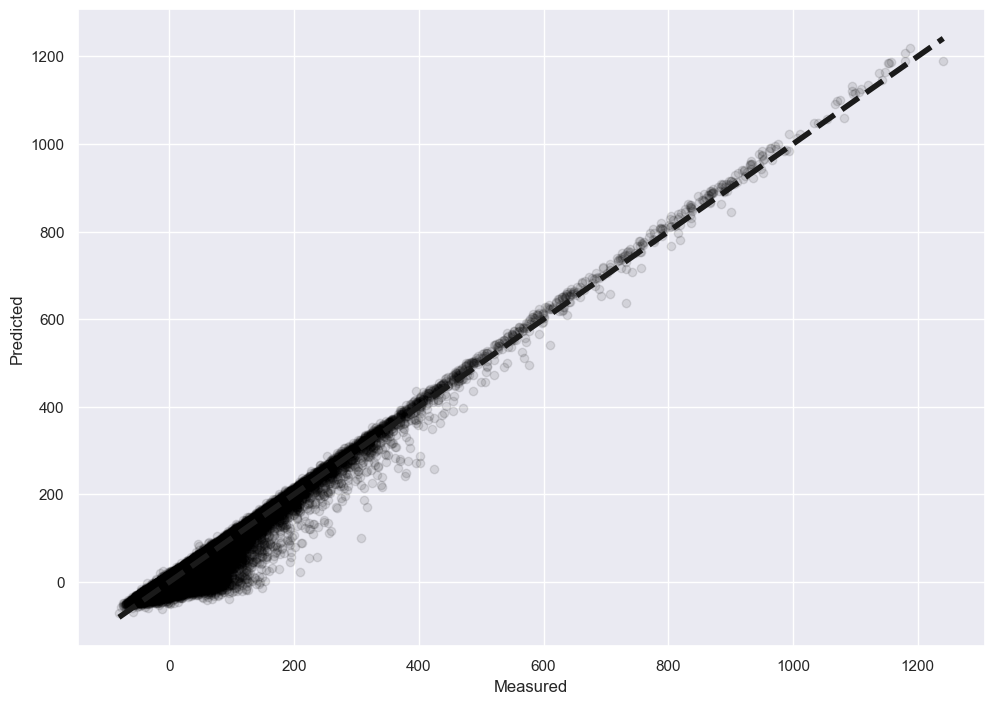

In [ ]:
# plot the results
plt.scatter(y_test, y_pred, color="black", alpha=0.1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

<AxesSubplot:>

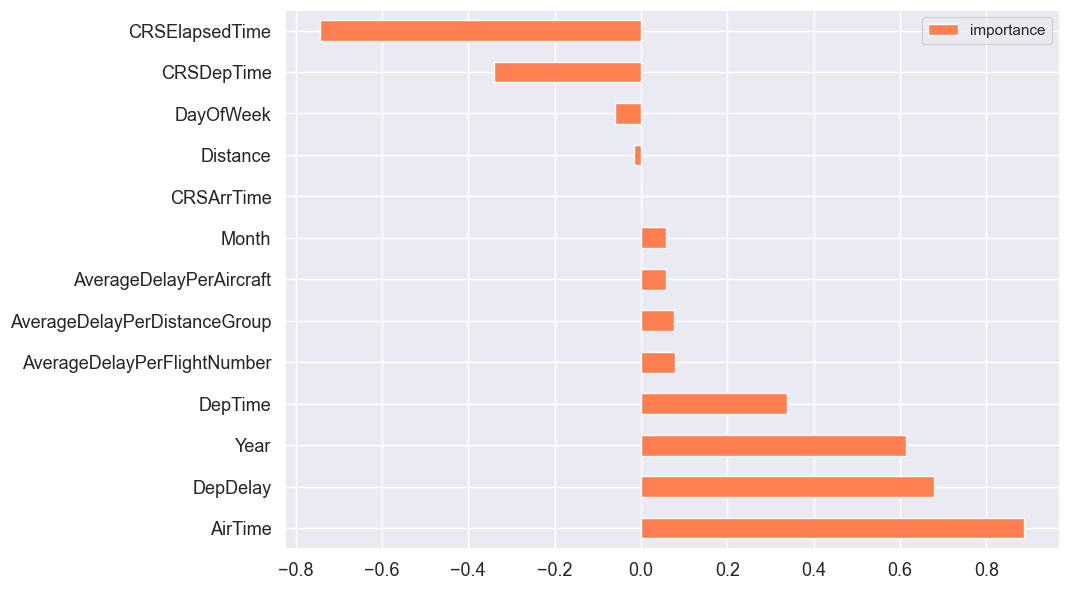

In [ ]:
feature_importance = pd.DataFrame(
    regr.coef_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importance.plot(kind="barh", figsize=(10, 7), color="coral", fontsize=13)

In [9]:
# do we have the same origins and destinations?
print(len(df["Origin"].unique()))
print(len(df["Dest"].unique()))

155
155


# Regression without departure data

In [34]:
# open the CSV delta_combined_flights_2018_2022
df = pd.read_csv("../data/delta_combined_flights_2018_2019_averages.csv")

df = df.fillna(0)
df = df.iloc[:, 1:]

# correct the timestamps to minutes
df["DepTimeMinutes"] = df["DepTime"].apply(lambda x: int(x / 100) * 60 + x % 100)
df["CRSDepTimeMinutes"] = df["CRSDepTime"].apply(lambda x: int(x / 100) * 60 + x % 100)
df["CRSArrTimeMinutes"] = df["CRSArrTime"].apply(lambda x: int(x / 100) * 60 + x % 100)

# transform as category
# df["Origin"] = df["Origin"].astype("category")
# df["Dest"] = df["Dest"].astype("category")
df["Tail_Number"] = df["Tail_Number"].astype("category")

features = [
    "FlightDate",
    "ArrDelay",
    "Distance",
    "Origin",
    "Dest",
    "CRSDepTime",
    "CRSElapsedTime",
    "CRSArrTime",
    "DayOfWeek",
    "Year",
    "Month",
    #"Tail_Number",
    "AverageDelayPerFlightNumber",
    "AverageDelayPerDistanceGroup",
    "AverageDelayPerAircraft",
]

# split the dataset based on the FlightDate for october 2019
data_regression = df[features]
data_regression.head()

# transform categorical features into dummy variables
data_regression = pd.get_dummies(data_regression, columns=["Origin", "Dest"], dtype="int")#, "Tail_Number"])

# # Substract Origin_ABE from Dest_ABE
airports = df["Origin"].unique()
for airport in tqdm(airports):
    data_regression[f"Origin_{airport}"].astype("float")   
    data_regression[f"Dest_{airport}"].astype("float")   
    data_regression[airport] = data_regression[f"Origin_{airport}"] - data_regression[f"Dest_{airport}"]
    data_regression.drop([f"Origin_{airport}", f"Dest_{airport}"], axis=1, inplace=True)

data_regression.head(10)

100%|██████████| 155/155 [01:54<00:00,  1.36it/s]


,FlightDate,ArrDelay,Distance,CRSDepTime,CRSElapsedTime,CRSArrTime,DayOfWeek,Year,Month,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,ATL,DTW,LAX,MSY,RDU,IAH,CLT,FLL,BNA,LGA,JAX,SLC,SEA,OAK,VPS,LIH,TLH,PHX,RIC,MCO,ORD,ABQ,OGG,MSP,PIT,CID,LIT,RSW,STL,PDX,MEM,ROA,GSP,IAD,BOS,FNT,HSV,MIA,...,SNA,ICT,KOA,BOI,BIL,SDF,BIS,AVP,SYR,MSN,SAV,MDT,GSO,RNO,EGE,TUL,XNA,COS,FAI,MHT,GPT,STT,STX,TYS,GRB,PHF,CAE,BTR,LFT,MOB,AVL,ABE,AGS,ILM,EVV,ONT,DSM,FCA,CRW,BTV,GNV,HPN,TVC,RAP,PSC,JNU,SBN,GTF,BUR,LGB
0,2018-01-01,-15.0,366.0,1205.0,82.0,1327,1,2018,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,-20.0,502.0,837.0,123.0,1040,1,2018,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,75.0,1747.0,1188.0,278.0,1326,1,2018,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,-14.0,1947.0,1340.0,308.0,1548,1,2018,1,0.0,0.0,0.0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,4.0,2486.0,1755.0,356.0,2151,1,2018,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2018-01-01,-22.0,590.0,560.0,118.0,858,1,2018,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2018-01-01,-13.0,1182.0,1158.0,177.0,1555,1,2018,1,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2018-01-01,2.0,2239.0,660.0,350.0,950,1,2018,1,0.0,0.0,0.0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2018-01-01,-21.0,645.0,2145.0,123.0,2348,1,2018,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2018-01-01,-1.0,689.0,600.0,123.0,903,1,2018,1,0.0,0.0,0.0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# data_regression.to_csv("../data/delta_combined_flights_2018_2019_averages_regression_ready.csv", index=False)

In [2]:
# data_regression = pd.read_csv("../data/delta_combined_flights_2018_2019_averages_regression_ready.csv")

In [3]:
df_train = data_regression[data_regression["FlightDate"] < "2019-10-01"]
df_test = data_regression[data_regression["FlightDate"] >= "2019-10-01"]

# drop FlightDate
df_train = df_train.drop("FlightDate", axis=1)
df_test = df_test.drop("FlightDate", axis=1)

# Get the arrays
X_train, y_train = df_train.drop("ArrDelay", axis=1), df_train["ArrDelay"]
X_test, y_test = df_test.drop("ArrDelay", axis=1), df_test["ArrDelay"]

### 1. Baseline: Linear Regression on continuous variables without departure delay data


In [37]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 1457.92
Coefficient of determination: -0.00


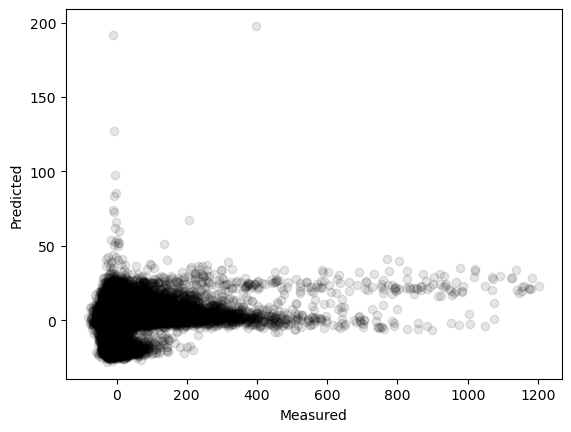

In [39]:
# plot the results
plt.scatter(y_test, y_pred, color="black", alpha=0.1)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

# plot the regression line
y_pred = regr.predict(X_test)

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.show()

<AxesSubplot:>

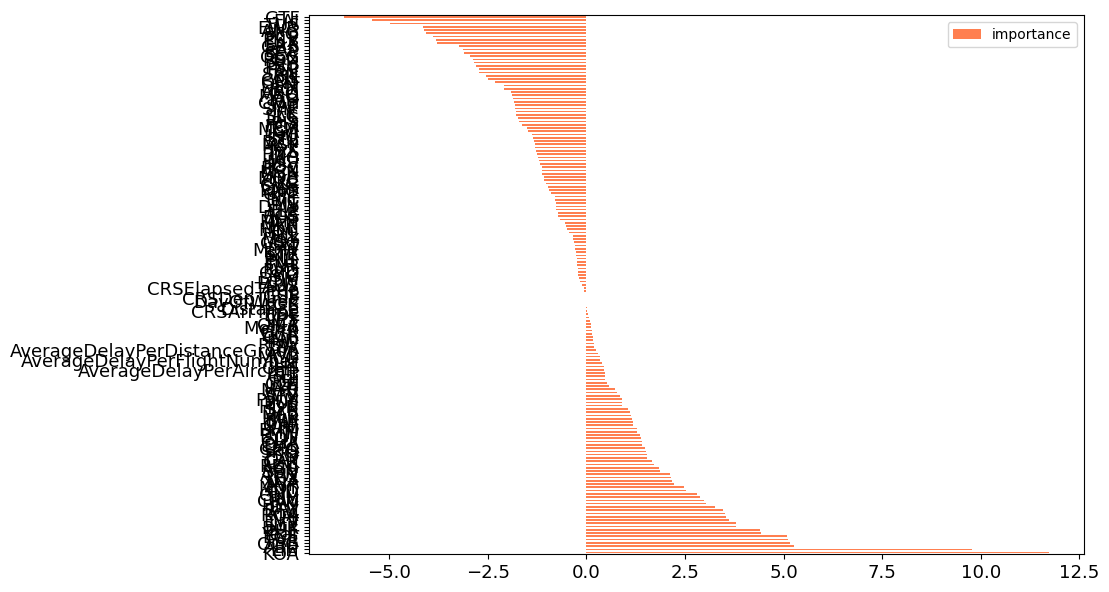

In [40]:
feature_importance = pd.DataFrame(
    regr.coef_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importance.plot(kind="barh", figsize=(10, 7), color="coral", fontsize=13)

We see here that our model send to completely underestimate the delay of most flights.


# Random Forest


In [41]:


# Create a random forest
rf = RandomForestRegressor(n_estimators=100, random_state=1601)

# Train the model using the training sets
rf.fit(X_train, y_train)

In [ ]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, color="black", alpha=0.1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

ValueError: could not convert string to float: 'LGA'

In [ ]:
## feature importance
feature_importance = pd.DataFrame(
    rf.feature_importances_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importance.plot(
    kind="barh",
    figsize=(10, 7),
    color="coral",
    fontsize=13,
    title="Random Forest Feature Importance",
)

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

# XGBoost


In [4]:
# XGBoost Regressor
xgb = XGBRegressor(n_estimators=50, random_state=1601)

# Train the model using the training sets
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=1601,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Mean squared error: 135.22
Coefficient of determination: 0.93


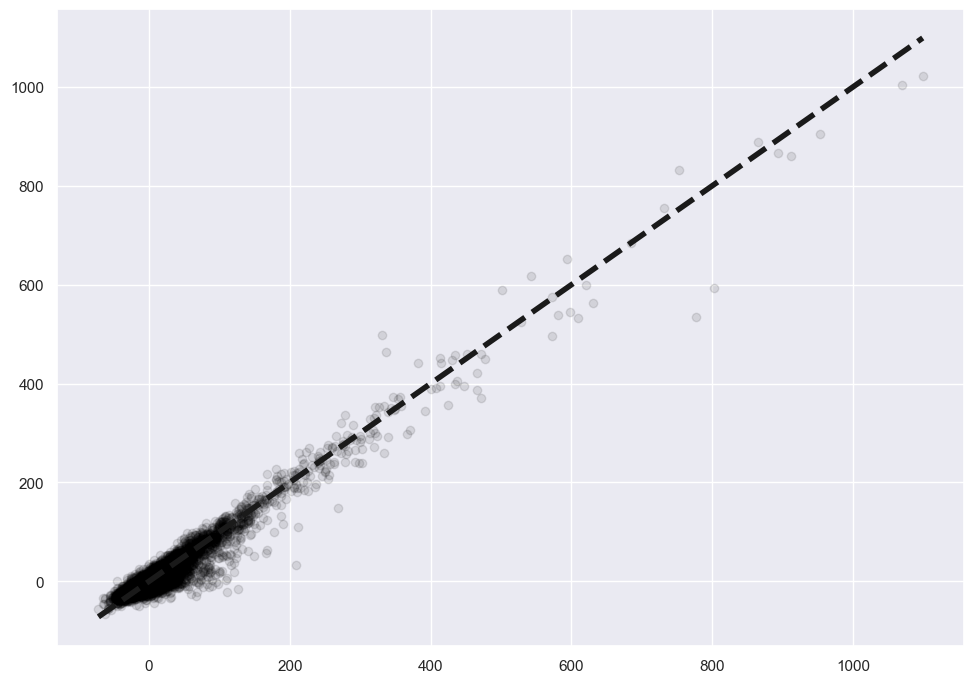

In [ ]:
# Make predictions using the testing set
y_pred = xgb.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, color="black", alpha=0.1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)

<AxesSubplot:title={'center':'XGBoost Feature Importance'}>

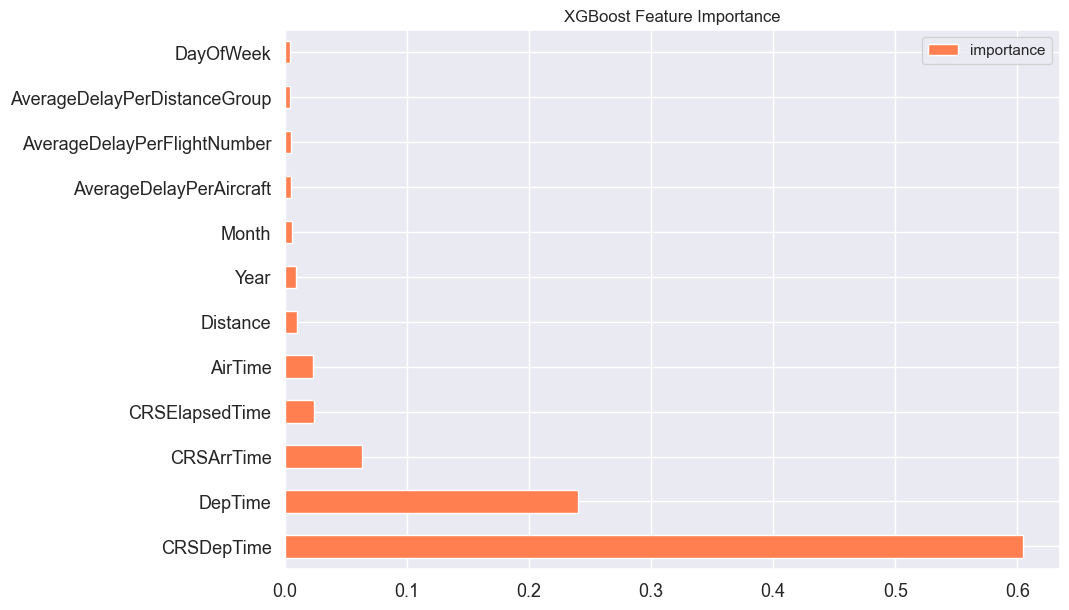

In [ ]:
## feature importance
feature_importance = pd.DataFrame(
    xgb.feature_importances_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importance.plot(
    kind="barh",
    figsize=(10, 7),
    color="coral",
    fontsize=13,
    title="XGBoost Feature Importance",
)